In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install chronos-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.1.1
    Uninstalling accelerate-1.1.1:
      Successfully uninstalled accelerate-1.1.1


In [4]:
import json
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from chronos import BaseChronosPipeline

In [5]:
with open('/content/drive/MyDrive/[인공지능기초]/predict/youtube/vader/vader_sentiment_analysis_harris.json', 'r') as f:
    harris_data = json.load(f)
with open('/content/drive/MyDrive/[인공지능기초]/predict/youtube/vader/vader_sentiment_analysis_trump.json', 'r') as f:
    trump_data = json.load(f)

In [6]:
harris_df = pd.DataFrame(list(harris_data.items()), columns=['date', 'score'])
harris_df['date'] = pd.to_datetime(harris_df['date'])
harris_df.set_index('date', inplace=True)
harris_df.sort_index(inplace=True)

trump_df = pd.DataFrame(list(trump_data.items()), columns=['date', 'score'])
trump_df['date'] = pd.to_datetime(trump_df['date'])
trump_df.set_index('date', inplace=True)
trump_df.sort_index(inplace=True)

In [51]:
# 예측 길이 설정 (3일 예측)
prediction_length = 3
quantile_levels = [0.9, 0.9, 0.9]  # 예측 구간 설정

In [13]:
# Chronos 모델 로드
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

In [50]:
# Harris 예측
harris_scores = harris_df['score'].values
quantiles_h, mean_h = pipeline.predict_quantiles(
    context=torch.tensor(harris_scores),
    prediction_length=prediction_length,
    quantile_levels=quantile_levels
)

forecast_index_h = pd.date_range(start=harris_df.index[-1] + pd.Timedelta(days=1), periods=prediction_length)
low_h, median_h, high_h = quantiles_h[0, :, 0].float().numpy(), quantiles_h[0, :, 1].float().numpy(), quantiles_h[0, :, 2].float().numpy()

prediction_df_harris = pd.DataFrame({'low':low_h, 'median':median_h, 'high':high_h}, index=forecast_index_h)


In [52]:
# Trump 예측
trump_scores = trump_df['score'].values
quantiles_t, mean_t = pipeline.predict_quantiles(
    context=torch.tensor(trump_scores),
    prediction_length=prediction_length,
    quantile_levels=quantile_levels
)

forecast_index_t = pd.date_range(start=trump_df.index[-1] + pd.Timedelta(days=1), periods=prediction_length)
low_t, median_t, high_t = quantiles_t[0, :, 0].float().numpy(), quantiles_t[0, :, 1].float().numpy(), quantiles_t[0, :, 2].float().numpy()

prediction_df_trump = pd.DataFrame({'low':low_t, 'median':median_t, 'high':high_t}, index=forecast_index_t)


In [56]:
prediction_df_harris

,low,median,high
2024-11-05,0.231523,0.231523,0.231523
2024-11-06,0.210988,0.210988,0.210988
2024-11-07,0.206913,0.206913,0.206913


In [57]:
prediction_df_trump

,low,median,high
2024-11-05,0.282031,0.282031,0.282031
2024-11-06,0.254460,0.254460,0.254460
2024-11-07,0.234871,0.234871,0.234871


In [67]:
# 과거 데이터와 예측 데이터가 끊기지 않고 자연스럽게 잇기거 데이터와 예측 데이터가 끊기지 않고 자연스럽게 잇기
harris_11_05 = pd.DataFrame({'score': [prediction_df_harris.loc['2024-11-05', 'median']]},
                             index=pd.to_datetime(['2024-11-05']))
trump_11_05 = pd.DataFrame({'score': [prediction_df_trump.loc['2024-11-05', 'median']]},
                            index=pd.to_datetime(['2024-11-05']))

harris_df_extended = pd.concat([harris_df, harris_11_05, prediction_df_harris], axis=0)
trump_df_extended = pd.concat([trump_df, trump_11_05, prediction_df_trump], axis=0)

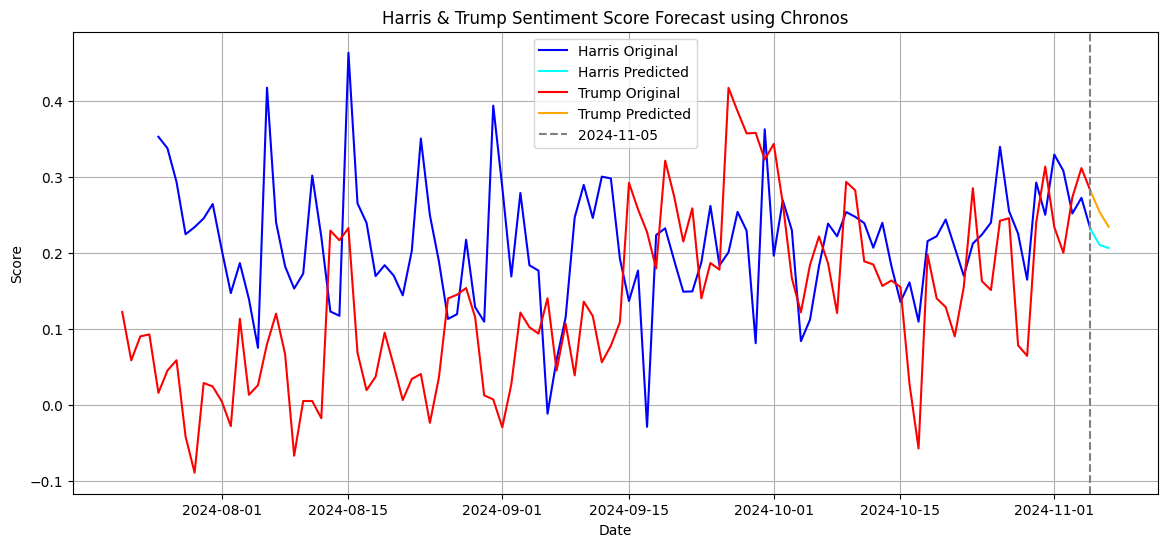

In [68]:
# Plot the extended data
plt.figure(figsize=(14, 6))

# Plot for Harris
plt.plot(harris_df_extended.index, harris_df_extended['score'], label='Harris Original', color='blue')
plt.plot(prediction_df_harris.index, prediction_df_harris['median'], label='Harris Predicted', color='cyan')

# Plot for Trump
plt.plot(trump_df_extended.index, trump_df_extended['score'], label='Trump Original', color='red')
plt.plot(prediction_df_trump.index, prediction_df_trump['median'], label='Trump Predicted', color='orange')

# Add vertical line at 2024-11-05
plt.axvline(pd.to_datetime('2024-11-05'), color='gray', linestyle='dashed', label='2024-11-05')

# Customize the plot
plt.title('Harris & Trump Sentiment Score Forecast using Chronos')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [70]:

# Filter the data for the specific date range (2024-11-02 to 2024-11-07)
date_range = pd.date_range(start='2024-11-02', end='2024-11-05')
pred_date_range = pd.date_range(start='2024-11-05', end='2024-11-07')

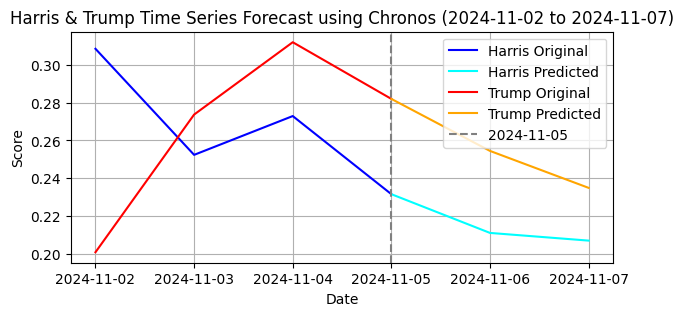

In [72]:
# Plot the extended data for the specified date range
plt.figure(figsize=(7, 3))

# Plot for Harris within the date range
harris_range = harris_df_extended.loc[date_range]
plt.plot(harris_range.index, harris_range['score'], label='Harris Original', color='blue')
harris_pred_range = prediction_df_harris.loc[pred_date_range]
plt.plot(harris_pred_range.index, harris_pred_range['median'], label='Harris Predicted', color='cyan')

# Plot for Trump within the date range
trump_range = trump_df_extended.loc[date_range]
plt.plot(trump_range.index, trump_range['score'], label='Trump Original', color='red')
trump_pred_range = prediction_df_trump.loc[pred_date_range]
plt.plot(trump_pred_range.index, trump_pred_range['median'], label='Trump Predicted', color='orange')

# Add vertical line at 2024-11-05
plt.axvline(pd.to_datetime('2024-11-05'), color='gray', linestyle='dashed', label='2024-11-05')

# Customize the plot
plt.title('Harris & Trump Time Series Forecast using Chronos (2024-11-02 to 2024-11-07)')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()